# IHDP Experiments

In [2]:
import pandas as pd 
import numpy as np
from scipy.stats import norm
import sys 

sys.path.append('../data/')
sys.path.append('../models/')
from falsifier import Falsifier
from baselines import MetaAnalyzer, EvolvedMetaAnalyzer, SimpleBaseline
from estimator import CATE
from DataModule import DataModule, test_params
from simulation import *

# Experiment 1 - One Dataset

## Loading Data

In [3]:
params = {
    'num_continuous': 4,
    'num_binary': 3,
    'omega': -23,
    'gamma_coefs': [0.1,0.2,0.5,0.75,1.], # alternate gamma_coefs [0.2,0.5,1.,1.5,2.], [0.2,0.5,.75,1.,1.25]
    'gamma_probs': [0.2,0.2,0.2,0.2,0.2], 
    'confounder_seed': 4, #0
    'beta_seed': 4,
    'noise_seed': 3, #0
    'obs_dict': {
        'num_obs': 5,
        'sizes': [10.,10.,10.,10.,10.], # 10
        'confounder_concealment': [0,0,2,4,6], # will be concealed according to ordering of coefficients
        'missing_bias': [False, False, False, False, False]
    }, 
    'rct_downsample': 1., 
    'reweighting': True, 
    'reweighting_factor': 0.2,
    'response_surface': {
        'ctr': 'non_linear', 
        'trt': 'linear',
        'model': 'MLP',
        'hp': {'hidden_layer_sizes': [(25,25)],
                'activation': ['relu'],
                'solver': ['adam'],
                'alpha': [.0001],
                'learning_rate': ['adaptive'],
                'learning_rate_init': [1e-3],
                'max_iter': [500]} 
    }
}
  
# root = '~/proj/rct_obs_causal/data/'
# generate 1 simulation of data
test_params(params)
ihdp_data = DataModule(params = params) # change root path to data and add it as argument
ihdp_data.generate_dataset()
data_dicts = ihdp_data.get_datasets()
print(f'data generation parameters: {params}')

[Generating confounders for dataset 1.]
[Simulating outcomes for dataset 1.]
[Generating confounders for dataset 2.]
[Simulating outcomes for dataset 2.]
[Generating confounders for dataset 3.]
[Simulating outcomes for dataset 3.]
[Generating confounders for dataset 4.]
[Simulating outcomes for dataset 4.]
[Generating confounders for dataset 5.]
[Simulating outcomes for dataset 5.]
[Generating confounders for dataset 6.]
[Simulating outcomes for dataset 6.]
data generation parameters: {'num_continuous': 4, 'num_binary': 3, 'omega': -23, 'gamma_coefs': [0.1, 0.2, 0.5, 0.75, 1.0], 'gamma_probs': [0.2, 0.2, 0.2, 0.2, 0.2], 'confounder_seed': 4, 'beta_seed': 4, 'noise_seed': 3, 'obs_dict': {'num_obs': 5, 'sizes': [10.0, 10.0, 10.0, 10.0, 10.0], 'confounder_concealment': [0, 0, 2, 4, 6], 'missing_bias': [False, False, False, False, False]}, 'rct_downsample': 1.0, 'reweighting': True, 'reweighting_factor': 0.2, 'response_surface': {'ctr': 'non_linear', 'trt': 'linear', 'model': 'MLP', 'hp': 

## Define Strata and get RCT CATE estimate and OBS estimates

In [19]:
 # estimate RCT CATE
strata = [
    (('b.marr','==',1,False),('bw','<',2000,True)), 
    (('b.marr','==',1,False),('bw','>=',2000,True)),
    (('b.marr','==',0,False),('bw','<',2000,True)),
    (('b.marr','==',0,False),('bw','>=',2000,True))            
]
strata_metadata = [
    ('lbw, married',True), # (group name, whether or not strata is supported on RCT)
    ('hbw, married',True),
    ('lbw, single',False),
    ('hbw, single',False)
]

In [20]:
cate_estimator = CATE(ihdp_data, strata=strata, strata_metadata=strata_metadata, params=params)
theta_hats, sd_hats = cate_estimator.rct_estimate(rct_table=data_dicts['rct-partial'])
strata_names_rct = cate_estimator.get_strata_names(only_rct=True)

In [ ]:
# estimate OBS CATE 
full_theta_obs = []; full_sd_obs = []
for k,obs_table in enumerate(data_dicts['obs']): 
    thetas_obs, sds_obs = cate_estimator.obs_estimate_reweight(obs_table=obs_table, rct_table=data_dicts['rct-partial'])
    full_theta_obs.append(thetas_obs); full_sd_obs.append(sds_obs)
strata_names_obs = cate_estimator.get_strata_names()

### Print out results

In [22]:
# "correct CATES"
true_cates = cate_estimator.true_cate(data_dicts['rct-full'])
for j,strata_name in enumerate(strata_names_obs):
    print(f'True CATE of {strata_name} group: {true_cates[j]}')

True CATE of lbw, married group: 4.190872951506137
True CATE of hbw, married group: 1.3253262732258886
True CATE of lbw, single group: 1.0892460057740605
True CATE of hbw, single group: -2.147069667564753


In [23]:
print('RCT CATEs')
for j,strata_name in enumerate(strata_names_rct): 
    print(f'mean (std) CATE of {strata_name} group: {theta_hats[j]} ({sd_hats[j]})')                           
print('')

obs_tables = data_dicts['obs']
for i,obs_table in enumerate(obs_tables): 
    print(f'OBS {i+1} CATEs:')
    for j,strata_name in enumerate(strata_names_obs):
        print(f'mean (std) CATE of {strata_name} group: {full_theta_obs[i][j]} ({full_sd_obs[i][j]})')
    print('=================================')

RCT CATEs
mean (std) CATE of lbw, married group: 4.877878841986647 (0.6536200125220313)
mean (std) CATE of hbw, married group: 2.624461377281584 (0.9887909485011986)

OBS 1 CATEs:
mean (std) CATE of lbw, married group: 4.374328149935404 (0.5398547671611978)
mean (std) CATE of hbw, married group: 1.233743478954628 (0.8307284046386023)
mean (std) CATE of lbw, single group: 1.128175718823744 (0.36984106744371725)
mean (std) CATE of hbw, single group: -1.9329506520539395 (0.5998537675817873)
OBS 2 CATEs:
mean (std) CATE of lbw, married group: 4.194378294456129 (0.5390967495555956)
mean (std) CATE of hbw, married group: 1.7046992327972719 (0.7723337598803771)
mean (std) CATE of lbw, single group: 0.8069527667377919 (0.2927239419060164)
mean (std) CATE of hbw, single group: -1.815211428735627 (0.28599910182594424)
OBS 3 CATEs:
mean (std) CATE of lbw, married group: 7.2176135405810165 (0.6509182511544322)
mean (std) CATE of hbw, married group: 4.691713207380874 (0.9182654249025535)
mean (std)

### Run validation algorithm

In [24]:
alpha=0.05

In [25]:
# run algorithm
falsifier = Falsifier(alpha=alpha)
(lci_out_aos, uci_out_aos), (lci_selected, uci_selected) = falsifier.run_validation(theta_hats, \
                    sd_hats, full_theta_obs, full_sd_obs, strata_names=strata_names_obs)

Selected obs studies: [0, 1]
Output 95.0% confidence interval for lbw, married: 2.9860453695592564, 5.584360097561046
Output 95.0% confidence interval for hbw, married: -0.6282534331012413, 3.435810228814533
Output 95.0% confidence interval for lbw, single: 0.15084052491437472, 1.957138496172417
Output 95.0% confidence interval for hbw, single: -3.2774645228758614, -0.5884367812320175


In [26]:
baseline = MetaAnalyzer(alpha=alpha)
lci_out_meta, uci_out_meta = baseline.compute_intervals(full_theta_obs, full_sd_obs, strata_names=strata_names_obs)

Meta-analysis 95.0% confidence interval for lbw, married: 4.605678393482092, 8.29141664481267
Meta-analysis 95.0% confidence interval for hbw, married: 1.8109902169643055, 5.545366419839906
Meta-analysis 95.0% confidence interval for lbw, single: 1.316205573882757, 5.091240703751184
Meta-analysis 95.0% confidence interval for hbw, single: -1.747938972270169, 2.23360276143162


In [27]:
lci_out_rct = []; uci_out_rct = []
for i in range(len(theta_hats)): 
    uci_out_rct.append(theta_hats[i] + norm.ppf(1-alpha/2) * sd_hats[i])
    lci_out_rct.append(theta_hats[i] - norm.ppf(1-alpha/2) * sd_hats[i])

In [28]:
simple_baseline = SimpleBaseline(alpha=alpha)
evo_baseline    = EvolvedMetaAnalyzer(alpha=alpha)
lci_out_simple, uci_out_simple = simple_baseline.compute_intervals(full_theta_obs, \
                                    full_sd_obs, strata_names=strata_names_obs)
lci_out_evo, uci_out_evo = evo_baseline.compute_intervals(full_theta_obs, \
                                    full_sd_obs, strata_names_obs, theta_hats, sd_hats)

Simple Baseline 95.0% confidence interval for lbw, married: 3.1377680811445523, 10.083654406135361
Simple Baseline 95.0% confidence interval for hbw, married: -0.39445427507144926, 7.505825161873856
Simple Baseline 95.0% confidence interval for lbw, single: 0.23322438318940464, 6.001791570962166
Simple Baseline 95.0% confidence interval for hbw, single: -3.1086424325049027, 2.9685999262651546
Meta-analysis 95.0% confidence interval for lbw, married: 3.5365658353404665, 5.03188776156137
Meta-analysis 95.0% confidence interval for hbw, married: 0.3777184024430529, 2.5949897930101966
Meta-analysis 95.0% confidence interval for lbw, single: 0.48080730764301194, 1.3805451977413912
Meta-analysis 95.0% confidence interval for hbw, single: -2.342999209881409, -1.331038232051573


# Experiment 2 - Multiple Dataset Simulation

In [29]:
strata = [
    (('b.marr','==',1,False),('bw','<',2000,True)), 
    (('b.marr','==',1,False),('bw','>=',2000,True)),
    (('b.marr','==',0,False),('bw','<',2000,True)),
    (('b.marr','==',0,False),('bw','>=',2000,True))            
]
strata_metadata = [
    ('lbw, married',True), # (group name, whether or not strata is supported on RCT)
    ('hbw, married',True),
    ('lbw, single',False),
    ('hbw, single',False)]

In [ ]:
%%time
conceal = [[0,0,0,0,0],[6,6,6,6]]
mod = []
template = {
                'num_obs': 5,
                'sizes': [5.,5.,5.,5.,5.],
                'confounder_concealment': [0,0,0,0,0],
                'missing_bias': [False,False,False,False,False]
            }
for i in conceal:
    template['confounder_concealment'] = i
    mod.append(template.copy())
    
R_all = []
for i in range(len(mod)):
    R = run_simulation(num_iters=1, strata=strata, \
                   strata_metadata=strata_metadata, alpha=0.05, \
                   root = '~/proj/rct_obs_causal/data/', params_mod = [('beta_seed',3),('obs_dict',mod[i])])
    R_all.append(R)

In [ ]:
%%time
## try parallelising things with multiprocessing
from multiprocessing import Pool, cpu_count
conceal = [[0,0,0,0,0],[6,6,6,6,6]]
mod = []
template = {
                'num_obs': 5,
                'sizes': [5.,5.,5.,5.,5.],
                'confounder_concealment': [0,0,0,0,0],
                'missing_bias': [False,False,False,False,False]
            }
for i in conceal:
    template['confounder_concealment'] = i
    mod.append(template.copy())
    
R_all = []
def simulation_run(modi): 
    R = run_simulation(num_iters=1, strata=strata, \
                   strata_metadata=strata_metadata, alpha=0.05, \
                   params_mod = [('beta_seed',3),('obs_dict',modi)])
    return R

procs = len(conceal)
jobs  = []
print(mod[0])
args = ((mod[0],),(mod[1],))
with Pool() as pool: 
    R_all = pool.starmap(simulation_run, args)

In [ ]:
print(R_all)

# Plotting

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

## alternate font/graph format
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rc('font', weight='heavy')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')

## Figure 1

In [31]:
from matplotlib.colors import ListedColormap

# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
my_cmap = ListedColormap(sns.color_palette(flatui).as_hex())

In [32]:
my_cmap(0.5)

(0.9058823529411765, 0.2980392156862745, 0.23529411764705882, 1.0)

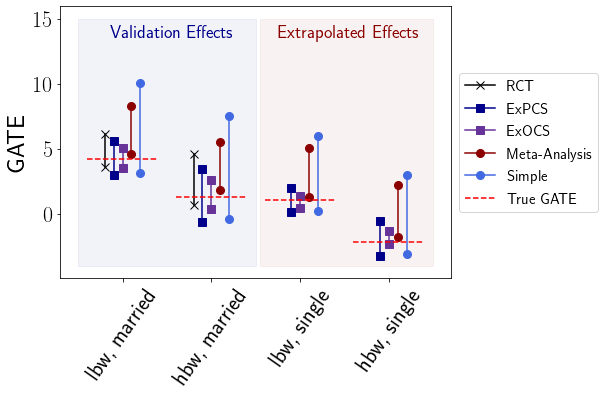

In [34]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
positions = []; labels = []
for d,strata in enumerate(strata_metadata): 
    name = strata[0]
    in_rct = strata[1]
    if d != 0: 
        label1, label2, label3, label4, label5, label6 = None, None, None, None, None, None
    else: 
        label1, label2, label3, label4, label5, label6 = 'ExPCS', 'RCT', 'Meta-Analysis','ExOCS', 'Simple', 'True GATE'
    if in_rct: 
        ax.plot((d-0.2,d-0.2),(lci_out_rct[d],uci_out_rct[d]), marker='x', ms=8, color='black', label=label2)
    ax.plot((d-0.1,d-0.1),(lci_out_aos[d],uci_out_aos[d]), marker='s', ms=8, color='darkblue', label=label1) # ours
    ax.plot((d,d),(lci_out_evo[d],uci_out_evo[d]), marker='s', ms=8, color='rebeccapurple', label=label4)
    ax.plot((d+0.1,d+0.1),(lci_out_meta[d],uci_out_meta[d]), marker='o', ms=8, color='darkred', label=label3)
    ax.plot((d+0.2,d+0.2),(lci_out_simple[d],uci_out_simple[d]), marker='o', ms=8, color='royalblue', label=label5)
    ax.plot((d-0.4,d+0.4),(true_cates[d],true_cates[d]),linestyle='--',color='red',label=label6)
    positions.append(d)
    labels.append(name)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim() 
ax.fill_between([-.5,1.5],-4,15,alpha=0.05,color='darkblue')
ax.fill_between([1.55,3.5],-4,15,alpha=0.05,color='darkred')
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(axis='x', labelsize=22)
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_ylabel('GATE',fontsize=25)
legend_properties = {'weight':'bold'}
for item in ax.get_xticklabels():
    item.set_rotation(55)
# ax.legend(fontsize=14,loc='lower left',ncol=2)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
t = ax.text(
    .55, 13.9, "Validation Effects", ha="center", va="center", size=18, color='darkblue', fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.32", fc="None", alpha=0., ec="darkblue", lw=2))
t = ax.text(
    2.55, 13.9, "Extrapolated Effects", ha="center", va="center", size=18, color='darkred', fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.32", fc="None", alpha=0., ec="darkred", lw=2))
fig.savefig('./plots/figure1_1sim_final_reweight_correction_second.pdf',bbox_inches='tight')

## Figure 2

In [3]:
strata = [
    (('b.marr','==',1,False),('bw','<',2000,True)), 
    (('b.marr','==',1,False),('bw','>=',2000,True)),
    (('b.marr','==',0,False),('bw','<',2000,True)),
    (('b.marr','==',0,False),('bw','>=',2000,True))            
]
strata_metadata = [
    ('lbw, married',True), # (group name, whether or not strata is supported on RCT)
    ('hbw, married',True),
    ('lbw, single',False),
    ('hbw, single',False)
]

In [54]:
path1 = '/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction'
path2 = '/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_round2'
files1 = [os.path.join(results_folder_path,elem) for elem in os.listdir(path1)]
files2 = [os.path.join(results_folder_path,elem) for elem in os.listdir(path2)]
files2 = [files2[0],files2[3],files2[2],files2[1]]
final_path = '/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_final'

for i in range(len(files1)): 
    thing1 = pd.read_csv(files1[i])
    thing2 = pd.read_csv(files2[i])
    print(files1[i])
    print(files2[i])
    assert files1[i].split('/')[-1] == files2[i].split('/')[-1]
    print(f'concatenating {files1[i]} and {files2[i]}')
    final_thing = pd.concat((thing1,thing2),axis=0).reset_index(drop=True)
    final_thing.to_csv(os.path.join(final_path,f'simulation{i}.csv'),index=False)
    

/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_round2/simulation0.csv
/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_round2/simulation0.csv
concatenating /afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_round2/simulation0.csv and /afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_round2/simulation0.csv
/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_round2/simulation1.csv
/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_round2/simulation1.csv
concatenating /afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_f

In [4]:
# - Figure 1: cove prob. and prob of selecting biased estimates as function of upsize ratio
## Read in csv files
import os
results_folder_path = '/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_final'
results_files = [os.path.join(results_folder_path,elem) for elem in os.listdir(results_folder_path) if 'csv' in elem]
## results_files = [results_files[0],results_files[3],results_files[2],results_files[1]] 
print(results_files)
x = [1.,3.,5.,10]
unbiased_estimators = [0,1]

# have a prob list for each strata
obs_strata_meta = [(i+1,elem[0]) for i,elem in enumerate(strata_metadata) if elem[1] != True]
prob_biased_lists = [[] for _ in range(len(obs_strata_meta))]
prob_biased_ci = [[] for _ in range(len(obs_strata_meta))]

method_name_dict = { 
    'ours': ('lci_out_aos','uci_out_aos'), 
    'meta': ('lci_out_meta','uci_out_meta'), 
    'evo': ('lci_out_evo','uci_out_evo'), 
    'simple': ('lci_out_simple','uci_out_simple')
}

coverage_prob_dict = {
    'ours': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'meta': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'evo': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'simple': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))])    
}

interval_width_dict = {
    'ours': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'meta': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'evo': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'simple': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))])    
}

for j,file in enumerate(results_files): 
    R = pd.read_csv(file)
    
    for i,stratum in enumerate(obs_strata_meta): 
        num = stratum[0]
        name = stratum[1]
        strata_table = R[R['strata_num'] == num]
        display(strata_table)
        
        # compute coverage probabilities        
        for k,v in method_name_dict.items(): 
            covered_truth = (strata_table['cate_true']>=strata_table[v[0]]) \
                &(strata_table['cate_true']<=strata_table[v[1]])
            coverage_prob = np.sum(covered_truth.astype('int').values) / len(covered_truth)
            ci = 1.96*np.sqrt((coverage_prob*(1-coverage_prob)) / len(covered_truth))
            coverage_prob_dict[k][0][i].append(coverage_prob)
            coverage_prob_dict[k][1][i].append(ci)
            interval_width = (strata_table[v[1]]-strata_table[v[0]]).abs().values
            width_mean = np.nanmean(interval_width)
            width_ci = 1.96*np.nanstd(interval_width)/np.sqrt(len(interval_width))
            interval_width_dict[k][0][i].append(width_mean)
            interval_width_dict[k][1][i].append(width_ci)
            print(f'x:{x[j]}, strata {name}, coverage_prob_{k}: {coverage_prob}, ci_{k}: {ci}, width_{k}: {width_mean}, width_ci_{k}: {width_ci}')

        
        # compute prob of selecting biased estimator 
        accepts = []
        for elem in strata_table['accept'].values: 
            if type(elem) != float:
                accepts.append(elem.split(','))
            else: 
                accepts.append([])
        
        num_biased_select = 0
        for accept in accepts: 
            if len(accept) == 0: 
                continue
            accept = [int(elem) for elem in accept]
            if len(accept) > len(unbiased_estimators): 
                num_biased_select += 1
            elif len(accept) < len(unbiased_estimators) \
                and accept[0] not in unbiased_estimators: 
                num_biased_select += 1
            elif len(accept) == len(unbiased_estimators) \
                and (accept[0] not in unbiased_estimators \
                     or accept[1] not in unbiased_estimators): 
                num_biased_select += 1
        prob_biased = float(num_biased_select) / len(accepts)
        prob_biased_lists[i].append(prob_biased)
        prob_ci = 1.96*np.sqrt((prob_biased*(1-prob_biased)) / len(accepts))
        prob_biased_ci[i].append(prob_ci)

for k in coverage_prob_dict.keys():
    print()
    print(coverage_prob_dict[k][0])
    print(coverage_prob_dict[k][1])
    print()
print('prob biased')
print(prob_biased_lists)
print(prob_biased_ci)
print()
for j in range(len(results_files)): 
    for i,stratum in enumerate(obs_strata_meta): 
        num = stratum[0]
        name = stratum[1]
        for k,v in method_name_dict.items(): 
            if k == 'simple' or k == 'ours': 
                print(f'x:{x[j]}, strata {name}, width_{k}: {interval_width_dict[k][0][i][j]}, width_ci_{k}: {interval_width_dict[k][1][i][j]}')
        print()


['/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_final/simulation0.csv', '/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_final/simulation1.csv', '/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_final/simulation2.csv', '/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/upsizemlp_full_reweight_correction_final/simulation3.csv']


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
2,2,0,3,"lbw, single",1.089246,NaN,NaN,-11.762580,9.061107,0.876116,...,0.778718,0.846269,2.400026,0.860640,-1.350736,4.645235,4.969592,1.043620,6.204636,0.806710
6,6,1,3,"lbw, single",1.089246,NaN,NaN,-13.761642,10.902253,0.738173,...,1.662660,1.596294,1.239984,0.607927,-1.429695,5.501888,5.271298,1.112096,5.749388,0.815869
10,10,2,3,"lbw, single",1.089246,NaN,NaN,-30.429035,9.682743,1.187412,...,0.448797,1.144513,-10.373146,8.947919,5.864456,1.411018,4.522197,1.005437,6.979832,0.729250
14,14,3,3,"lbw, single",1.089246,NaN,NaN,-5.824448,13.871659,1.406396,...,1.417084,3.230804,0.978622,0.753097,6.669494,3.213240,5.231514,0.775288,5.812430,0.933777
18,18,4,3,"lbw, single",1.089246,NaN,NaN,-27.478524,83.653735,1.529438,...,8.187904,6.147655,-0.278768,1.490344,28.087605,24.790783,5.067969,0.785203,6.026482,0.698544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,182,45,3,"lbw, single",1.089246,NaN,NaN,-1.264092,9.906022,0.618965,...,-0.008201,0.560315,13.711208,12.703997,5.114807,2.137596,5.788878,1.140163,5.695820,0.745289
386,186,46,3,"lbw, single",1.089246,NaN,NaN,-9.012332,6.064591,1.325147,...,-3.423808,2.493315,2.445550,0.841184,3.635032,1.083946,3.980498,1.116989,5.314725,0.814600
390,190,47,3,"lbw, single",1.089246,NaN,NaN,-3.896446,6.775654,0.680884,...,1.439604,2.380674,1.005594,0.540322,2.421074,1.255274,4.754441,1.306612,7.001390,0.957810
394,194,48,3,"lbw, single",1.089246,NaN,NaN,-1.894225,9.493864,0.780425,...,1.326259,0.686551,0.771623,1.189366,6.175667,1.349526,2.835693,3.243748,7.063191,1.084443


x:1.0, strata lbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 21.18230177312124, width_ci_ours: 3.8095150719478794
x:1.0, strata lbw, single, coverage_prob_meta: 0.46, ci_meta: 0.09768589662791656, width_meta: 4.866084837719093, width_ci_meta: 0.20590893560897228
x:1.0, strata lbw, single, coverage_prob_evo: 0.82, ci_evo: 0.07530074103221031, width_evo: 5.020315130220257, width_ci_evo: 0.44924611048743257
x:1.0, strata lbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 21.063271908347314, width_ci_simple: 3.3064918570852364


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
3,3,0,4,"hbw, single",-2.14707,NaN,NaN,-8.763245,4.523519,-0.137941,...,-0.396542,1.695784,-2.119863,2.963939,0.845822,1.272206,3.888894,1.102721,2.623445,1.127907
7,7,1,4,"hbw, single",-2.14707,NaN,NaN,-212.575758,71.949693,-2.603795,...,-2.374391,1.055586,-1.941518,1.510302,-70.313033,63.470399,2.427275,0.957298,4.160695,0.960605
11,11,2,4,"hbw, single",-2.14707,NaN,NaN,-67.029154,25.387553,0.470225,...,-20.820800,20.615819,-13.240588,10.192566,1.062406,0.935572,2.615822,0.991367,3.435583,1.113673
15,15,3,4,"hbw, single",-2.14707,NaN,NaN,-11.707584,4.512296,-0.669173,...,-1.073281,1.173164,-4.118253,3.385974,1.174486,1.244136,2.406968,0.939290,2.707683,0.935585
19,19,4,4,"hbw, single",-2.14707,NaN,NaN,-12.588168,7.321161,-0.564802,...,-4.558572,3.582398,1.377018,2.651974,0.888561,1.622608,1.809844,2.135205,3.954732,0.904986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,183,45,4,"hbw, single",-2.14707,NaN,NaN,-4.630957,5.081245,-2.566019,...,-2.930446,0.758682,-1.519077,0.653712,1.103035,1.729368,0.105943,1.962644,3.118734,0.875572
387,187,46,4,"hbw, single",-2.14707,NaN,NaN,-23.613079,7.132694,-2.467501,...,-2.422812,1.000040,-8.240192,6.858601,0.605344,1.069737,0.958812,1.728212,0.789135,2.760652
391,191,47,4,"hbw, single",-2.14707,NaN,NaN,-3.954177,3.687605,-0.823165,...,0.155981,0.797773,-2.044578,0.851966,1.417933,1.012612,2.110313,0.681725,3.389009,1.254655
395,195,48,4,"hbw, single",-2.14707,NaN,NaN,-9.494031,5.652848,-2.310728,...,-3.207789,2.804602,-1.910339,0.784924,0.920630,1.028235,4.956527,5.742911,1.536021,1.836719


x:1.0, strata hbw, single, coverage_prob_ours: 0.98, ci_ours: 0.02744000000000001, width_ours: 24.855085596311472, width_ci_ours: 7.835644744529112
x:1.0, strata hbw, single, coverage_prob_meta: 0.34, ci_meta: 0.09284691917344376, width_meta: 4.462437205825222, width_ci_meta: 0.221388721340039
x:1.0, strata hbw, single, coverage_prob_evo: 0.58, ci_evo: 0.09673746740534404, width_evo: 5.425023548007562, width_ci_evo: 0.7572334975975278
x:1.0, strata hbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 26.29496297271381, width_ci_simple: 7.263942004538241


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
2,2,0,3,"lbw, single",1.089246,NaN,NaN,-1.225062,6.061062,1.032129,...,0.320714,0.689647,0.433159,0.545001,4.670396,0.620444,4.837626,0.423946,5.807498,0.377142
6,6,1,3,"lbw, single",1.089246,NaN,NaN,-0.696942,5.574213,1.157012,...,1.452528,0.364395,0.532148,0.548357,4.322453,0.558472,4.026477,0.862657,5.366278,0.398269
10,10,2,3,"lbw, single",1.089246,NaN,NaN,-0.457975,6.055013,1.777733,...,1.099670,0.542680,1.586844,0.912294,4.308324,0.779284,5.048461,0.445971,4.819012,0.385290
14,14,3,3,"lbw, single",1.089246,NaN,NaN,-0.795658,5.150640,1.092869,...,1.481696,1.016040,0.364350,0.361384,4.159233,0.442315,4.891805,0.557758,5.249171,0.370299
18,18,4,3,"lbw, single",1.089246,NaN,NaN,-1.894364,7.273568,1.137929,...,2.689602,2.045133,0.368639,0.344143,3.359418,0.472506,5.030890,0.477124,4.904085,0.398293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,182,45,3,"lbw, single",1.089246,NaN,NaN,-0.308052,5.952877,1.129471,...,0.653084,0.428810,1.339728,0.862817,3.040932,0.547138,4.910324,0.465134,5.117513,0.371064
386,186,46,3,"lbw, single",1.089246,NaN,NaN,-1.259697,4.292584,0.141990,...,-0.378372,0.393202,0.862515,0.337406,2.609348,0.750974,5.408469,0.452328,6.575631,0.353041
390,190,47,3,"lbw, single",1.089246,NaN,NaN,-0.698911,7.396698,2.130001,...,0.538166,0.551921,3.816460,1.597320,4.171708,0.332162,4.680816,0.460383,5.576093,0.371682
394,194,48,3,"lbw, single",1.089246,NaN,NaN,-7.955803,4.597200,0.306770,...,-1.689278,2.795805,0.580455,0.700408,1.760999,1.265369,3.750487,0.536824,5.504064,0.404364


x:3.0, strata lbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 9.506692927894177, width_ci_ours: 2.1759668547435442
x:3.0, strata lbw, single, coverage_prob_meta: 0.4, ci_meta: 0.09601999791710057, width_meta: 3.975330957137728, width_ci_meta: 0.15461449166119706
x:3.0, strata lbw, single, coverage_prob_evo: 0.86, ci_evo: 0.06800945816575808, width_evo: 3.63119278707011, width_ci_evo: 0.29719171889156165
x:3.0, strata lbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 10.204208907239153, width_ci_simple: 1.8565351956530463


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
3,3,0,4,"hbw, single",-2.14707,NaN,NaN,-4.969874,4.039449,-1.359598,...,-2.726208,1.001010,-1.170846,0.375266,2.659145,0.615821,1.808814,0.716618,2.856408,0.490072
7,7,1,4,"hbw, single",-2.14707,NaN,NaN,-6.023407,1.744105,-2.244695,...,-1.611503,0.371939,-3.306821,1.212003,-0.451625,0.979623,1.491822,0.493711,2.832115,0.440104
11,11,2,4,"hbw, single",-2.14707,NaN,NaN,-8.364947,2.697232,-2.572861,...,-4.455937,1.744001,-2.449485,0.437975,0.784068,0.853557,1.773644,0.680476,2.069104,0.520185
15,15,3,4,"hbw, single",-2.14707,NaN,NaN,-4.031634,2.565350,-2.303470,...,-2.984532,0.467164,-2.089583,0.644027,0.991849,0.702016,1.754891,0.627396,2.631562,0.535211
19,19,4,4,"hbw, single",-2.14707,NaN,NaN,-3.687438,2.012829,-2.015855,...,-2.084031,0.478050,-2.576921,0.495456,0.772931,0.553179,1.340787,0.588724,2.299559,0.493368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,183,45,4,"hbw, single",-2.14707,NaN,NaN,-3.889486,2.593834,-2.388848,...,-2.643212,0.556024,-2.366891,0.667150,-0.140375,1.105308,1.545334,0.467787,2.175694,0.510293
387,187,46,4,"hbw, single",-2.14707,NaN,NaN,-4.346029,2.131593,-2.118952,...,-0.728917,1.062113,-3.261999,0.483639,0.666019,0.653865,1.304549,0.484207,1.795705,0.494622
391,191,47,4,"hbw, single",-2.14707,NaN,NaN,-6.376861,8.646389,-0.799803,...,1.134764,3.351305,-1.462578,0.702105,0.096430,0.514015,0.533129,0.651768,1.271239,0.529172
395,195,48,4,"hbw, single",-2.14707,NaN,NaN,-5.937705,0.968446,-1.484733,...,-2.613866,1.482928,-1.476558,0.667940,-0.144230,0.496420,1.315028,0.869736,1.960514,0.495287


x:3.0, strata hbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 8.293971717527329, width_ci_ours: 0.850491087569521
x:3.0, strata hbw, single, coverage_prob_meta: 0.44, ci_meta: 0.09729184138456833, width_meta: 4.020852059750544, width_ci_meta: 0.14247429521080307
x:3.0, strata hbw, single, coverage_prob_evo: 0.88, ci_evo: 0.06369246109234593, width_evo: 3.582685137075556, width_ci_evo: 0.3336639861696635
x:3.0, strata hbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 9.153751740457256, width_ci_simple: 0.6039204482027116


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
2,2,0,3,"lbw, single",1.089246,NaN,NaN,-0.318746,4.374628,1.801166,...,2.027941,1.046972,1.151672,0.397465,3.798824,0.397432,4.287586,0.401390,5.187115,0.293928
6,6,1,3,"lbw, single",1.089246,NaN,NaN,0.030396,6.197108,1.400556,...,1.144998,0.239877,2.372490,1.044923,4.404533,0.799756,4.351857,0.401523,5.579056,0.296815
10,10,2,3,"lbw, single",1.089246,NaN,NaN,-0.125692,5.632969,1.272992,...,1.733160,0.439987,1.169921,0.316609,2.753639,1.284611,5.014230,0.319540,5.299066,0.297604
14,14,3,3,"lbw, single",1.089246,NaN,NaN,-1.853073,4.296758,1.647297,...,0.207553,0.919346,1.844884,0.473787,3.611114,0.305899,3.855804,0.341641,6.035007,0.297580
18,18,4,3,"lbw, single",1.089246,NaN,NaN,-2.260213,12.660175,1.568078,...,0.396457,1.185271,1.655737,0.358274,6.021300,2.961929,5.112911,0.319972,5.257057,0.290895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,182,45,3,"lbw, single",1.089246,NaN,NaN,0.027150,5.835892,0.949954,...,0.820299,0.331351,0.603258,0.257030,3.683969,0.414222,5.020291,0.363880,5.382910,0.283158
386,186,46,3,"lbw, single",1.089246,NaN,NaN,-0.611622,4.455189,1.007090,...,0.710349,0.292387,0.630594,0.554214,3.743961,0.317314,4.292376,0.399178,5.645170,0.298134
390,190,47,3,"lbw, single",1.089246,NaN,NaN,-0.751312,6.857764,0.587694,...,0.586365,0.287297,1.489169,0.999588,3.797641,1.365271,4.139454,0.524466,5.353957,0.286874
394,194,48,3,"lbw, single",1.089246,NaN,NaN,0.665655,4.807610,1.701324,...,1.426202,0.339317,1.452176,0.291661,3.966850,0.375104,4.803461,0.342793,5.247425,0.277748


x:5.0, strata lbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 5.531299869576234, width_ci_ours: 0.5963224171193849
x:5.0, strata lbw, single, coverage_prob_meta: 0.3, ci_meta: 0.08981848362113447, width_meta: 3.7818787939460163, width_ci_meta: 0.11904765045962284
x:5.0, strata lbw, single, coverage_prob_evo: 0.96, ci_evo: 0.03840799916684025, width_evo: 2.7029798615858187, width_ci_evo: 0.2580862857520823
x:5.0, strata lbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 6.950412873932907, width_ci_simple: 0.38618250281430166


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
3,3,0,4,"hbw, single",-2.14707,NaN,NaN,-3.202730,-0.344677,-1.346146,...,-1.773703,0.637559,-1.711978,0.405951,0.818023,0.397922,1.342529,0.437315,2.050591,0.381738
7,7,1,4,"hbw, single",-2.14707,NaN,NaN,-3.299175,3.884095,-1.863452,...,-1.933136,0.384579,-2.332122,0.431450,1.573835,1.030720,1.564344,0.467217,1.935788,0.387503
11,11,2,4,"hbw, single",-2.14707,NaN,NaN,-3.134367,2.393598,-1.788774,...,-1.962116,0.318805,-2.148115,0.440015,0.949036,0.644490,1.622517,0.404511,2.024281,0.424021
15,15,3,4,"hbw, single",-2.14707,NaN,NaN,-3.305900,0.840503,-2.168307,...,-2.113935,0.329103,-2.264295,0.464711,-0.570837,0.629668,1.220296,0.374176,2.160760,0.401730
19,19,4,4,"hbw, single",-2.14707,NaN,NaN,-3.554805,2.576581,-2.008543,...,-2.288145,0.565119,-1.871424,0.508152,0.464629,0.942246,1.446695,0.590406,2.170928,0.364528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,183,45,4,"hbw, single",-2.14707,NaN,NaN,-3.066970,2.624972,-1.854906,...,-2.038063,0.459046,-1.660568,0.308976,-0.466102,0.552437,1.540237,0.483954,2.183534,0.374497
387,187,46,4,"hbw, single",-2.14707,NaN,NaN,-6.341335,2.345461,-2.373629,...,-4.092659,1.003245,-1.398390,0.413103,-0.629901,1.327455,1.891162,0.470793,2.237224,0.378382
391,191,47,4,"hbw, single",-2.14707,NaN,NaN,-2.741030,2.930686,-1.514477,...,-2.021295,0.321109,-1.464201,0.367978,1.449555,0.660805,1.364962,0.420186,2.210530,0.395424
395,195,48,4,"hbw, single",-2.14707,NaN,NaN,-14.493664,2.893430,-1.480752,...,-5.800117,3.878619,-1.699470,0.410349,0.121781,0.498476,1.838915,0.419843,2.121490,0.380258


x:5.0, strata hbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 5.364628443675041, width_ci_ours: 0.5303370651908983
x:5.0, strata hbw, single, coverage_prob_meta: 0.26, ci_meta: 0.08597231182188834, width_meta: 3.7143243716872534, width_ci_meta: 0.09878422627444407
x:5.0, strata hbw, single, coverage_prob_evo: 0.92, ci_evo: 0.05317346706770209, width_evo: 2.806060388857118, width_ci_evo: 0.2551301304755526
x:5.0, strata hbw, single, coverage_prob_simple: 0.98, ci_simple: 0.02744000000000001, width_simple: 6.896209565426887, width_ci_simple: 0.35136634655699384


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
2,2,0,3,"lbw, single",1.089246,NaN,NaN,0.177985,1.687906,1.190661,...,1.165105,0.233247,0.902778,0.323366,3.211413,0.308232,4.922805,0.285199,5.522132,0.204764
6,6,1,3,"lbw, single",1.089246,NaN,NaN,0.223800,1.296249,0.935079,...,0.765507,0.236790,0.710137,0.216979,3.902017,0.283846,4.869523,0.350309,5.847140,0.196757
10,10,2,3,"lbw, single",1.089246,NaN,NaN,0.280628,4.448189,0.840581,...,0.929549,0.209268,0.716242,0.194349,3.328339,0.499620,4.496332,0.217183,5.778910,0.194519
14,14,3,3,"lbw, single",1.089246,NaN,NaN,0.291325,4.948188,1.026761,...,0.973525,0.304363,1.202920,0.226199,3.284763,0.742136,4.241744,0.260186,5.511541,0.205581
18,18,4,3,"lbw, single",1.089246,NaN,NaN,0.592173,1.656024,1.298149,...,1.124098,0.237318,1.034404,0.189159,3.546509,0.252381,4.531042,0.221771,5.491071,0.202348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,182,45,3,"lbw, single",1.089246,NaN,NaN,0.532169,4.978460,1.226081,...,0.954398,0.176292,1.141594,0.271894,4.068888,0.405805,4.833714,0.236772,5.320847,0.196512
386,186,46,3,"lbw, single",1.089246,NaN,NaN,0.019072,1.549127,0.984142,...,0.574975,0.235478,0.784099,0.341316,3.516692,0.244025,4.479335,0.285071,5.433953,0.203085
390,190,47,3,"lbw, single",1.089246,NaN,NaN,-1.115729,2.676166,1.604735,...,0.780219,0.845875,1.279543,0.320055,3.200072,0.234014,4.887324,0.243281,5.678703,0.201221
394,194,48,3,"lbw, single",1.089246,NaN,NaN,0.375138,4.801483,1.288633,...,0.857291,0.215112,1.263693,0.216783,4.050086,0.335235,4.994738,0.267276,5.526373,0.199593


x:10, strata lbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 3.57963316833724, width_ci_ours: 0.2951866201604478
x:10, strata lbw, single, coverage_prob_meta: 0.2, ci_meta: 0.0784, width_meta: 3.8958055366444713, width_ci_meta: 0.06431047031311202
x:10, strata lbw, single, coverage_prob_evo: 0.96, ci_evo: 0.03840799916684025, width_evo: 2.187279160874998, width_ci_evo: 0.2544488478659513
x:10, strata lbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 5.689314702527006, width_ci_simple: 0.11943089992652675


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
3,3,0,4,"hbw, single",-2.14707,NaN,NaN,-3.023937,-0.420149,-2.121316,...,-2.462552,0.250462,-1.346397,0.413245,0.460062,1.132746,1.019235,0.322959,2.235622,0.277789
7,7,1,4,"hbw, single",-2.14707,NaN,NaN,-5.009484,0.322398,-2.162024,...,-2.679214,0.304550,-2.343543,1.189407,0.887803,0.582659,1.221655,0.297463,1.985566,0.263139
11,11,2,4,"hbw, single",-2.14707,NaN,NaN,-3.072537,1.730757,-1.839405,...,-2.195778,0.391165,-1.697402,0.299157,0.321314,0.628822,1.640892,0.288130,2.538057,0.265867
15,15,3,4,"hbw, single",-2.14707,NaN,NaN,-3.500803,1.106147,-1.965992,...,-1.844795,0.250423,-2.693840,0.360026,0.355716,0.334804,1.609807,0.310205,2.362313,0.268768
19,19,4,4,"hbw, single",-2.14707,NaN,NaN,-3.049303,-1.230527,-1.722561,...,-1.825065,0.265252,-2.237750,0.362074,0.492727,0.331548,1.803435,0.271256,2.541749,0.280455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,183,45,4,"hbw, single",-2.14707,NaN,NaN,-4.203742,1.970002,-2.147992,...,-2.254043,0.263999,-2.961241,0.554341,1.146410,0.367445,1.697088,0.349041,2.743971,0.263106
387,187,46,4,"hbw, single",-2.14707,NaN,NaN,-3.443589,2.758177,-1.507071,...,-2.340329,0.261934,-0.342706,1.383456,1.072764,0.368026,1.338286,0.278465,2.070768,0.287629
391,191,47,4,"hbw, single",-2.14707,NaN,NaN,-2.751298,-1.403703,-1.970944,...,-2.051732,0.289117,-2.169155,0.259723,0.296595,0.381326,1.172891,0.323823,2.255548,0.260693
395,195,48,4,"hbw, single",-2.14707,NaN,NaN,-3.443282,1.349712,-1.905184,...,-2.371051,0.478375,-1.927150,0.238117,0.456638,0.398444,1.185184,0.332281,2.084143,0.281358


x:10, strata hbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 4.341923807285386, width_ci_ours: 0.4369452973812515
x:10, strata hbw, single, coverage_prob_meta: 0.2, ci_meta: 0.0784, width_meta: 3.8262451492213767, width_ci_meta: 0.07915164780909525
x:10, strata hbw, single, coverage_prob_evo: 0.98, ci_evo: 0.02744000000000001, width_evo: 2.6038408765640253, width_ci_evo: 0.2745419515326787
x:10, strata hbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 6.328505270363092, width_ci_simple: 0.2024394474279525

[[1.0, 1.0, 1.0, 1.0], [0.98, 1.0, 1.0, 1.0]]
[[0.0, 0.0, 0.0, 0.0], [0.02744000000000001, 0.0, 0.0, 0.0]]


[[0.46, 0.4, 0.3, 0.2], [0.34, 0.44, 0.26, 0.2]]
[[0.09768589662791656, 0.09601999791710057, 0.08981848362113447, 0.0784], [0.09284691917344376, 0.09729184138456833, 0.08597231182188834, 0.0784]]


[[0.82, 0.86, 0.96, 0.96], [0.58, 0.88, 0.92, 0.98]]
[[0.07530074103221031, 0.06800945816575808, 0.03840799916684025, 0.03840799916684025], [0.09

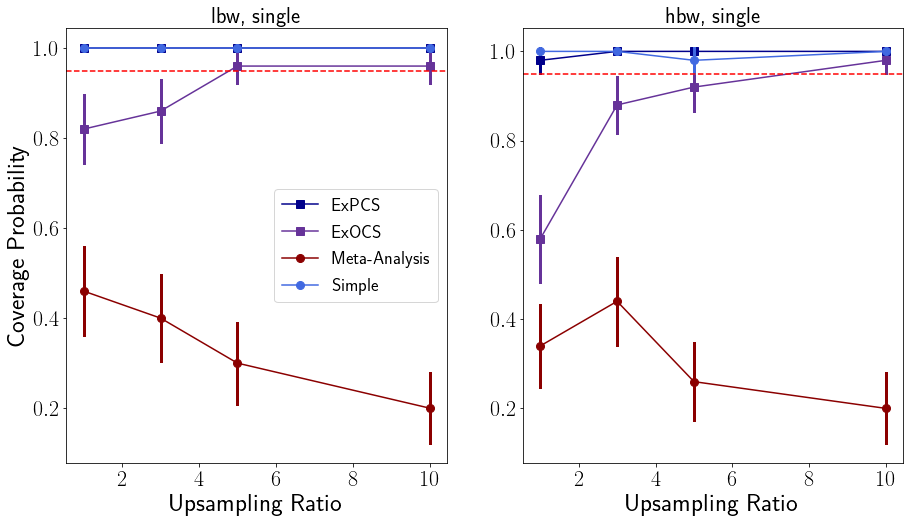

In [57]:
fig, axlist = plt.subplots(1,2,figsize=(15,8))
axs = axlist.ravel()
for i,_ in enumerate(obs_strata_meta): 
    ax = axs[i]
    
    '''
    prob_biased = np.array(prob_biased_lists[i])
    prob_ci = np.array(prob_biased_ci[i])
    ax.plot(x, prob_biased, color='darkblue', marker='x', ms=8, linewidth=4, linestyle='-.', label='$P($selecting biased estimator$)$')
    for k,ci in enumerate(prob_ci): 
        ax.plot((x[k],x[k]),(prob_biased[k]-ci,prob_biased[k]+ci), linewidth=3, color='darkblue') # ours  
    '''
    coverage_prob_ours = np.array(coverage_prob_dict['ours'][0][i])
    ours_ci = np.array(coverage_prob_dict['ours'][1][i])
    coverage_prob_meta = np.array(coverage_prob_dict['meta'][0][i])
    meta_ci = np.array(coverage_prob_dict['meta'][1][i])
    coverage_prob_evo = np.array(coverage_prob_dict['evo'][0][i])
    evo_ci  = np.array(coverage_prob_dict['evo'][1][i])
    coverage_prob_simple = np.array(coverage_prob_dict['simple'][0][i])
    simple_ci  = np.array(coverage_prob_dict['simple'][1][i])

    ax.plot(x, coverage_prob_ours, marker='s', color='darkblue', ms=8, linewidth=1.5, label='ExPCS')
    for k,ci in enumerate(ours_ci): 
        ax.plot((x[k],x[k]),(coverage_prob_ours[k]-ci,coverage_prob_ours[k]+ci), linewidth=3, color='darkblue') 
        
    ax.plot(x, coverage_prob_evo, marker='s', color='rebeccapurple', ms=8, linewidth=1.5, label='ExOCS')
    for k,ci in enumerate(evo_ci): 
        ax.plot((x[k],x[k]),(coverage_prob_evo[k]-ci,coverage_prob_evo[k]+ci), linewidth=3, color='rebeccapurple') 
        
    ax.plot(x, coverage_prob_meta, marker='o', color='darkred', ms=8, linewidth=1.5, label='Meta-Analysis')
    for k,ci in enumerate(meta_ci): 
        ax.plot((x[k],x[k]),(coverage_prob_meta[k]-ci,coverage_prob_meta[k]+ci), linewidth=3, color='darkred') 
        
    ax.plot(x, coverage_prob_simple, marker='o', color='royalblue', ms=8, linewidth=1.5, label='Simple')
    for k,ci in enumerate(simple_ci): 
        ax.plot((x[k],x[k]),(coverage_prob_simple[k]-ci,coverage_prob_simple[k]+ci), linewidth=3, color='royalblue') 
        
    xmin, xmax = ax.get_xlim()
    ax.axhline(y=0.95,xmin=0,xmax=xmax,color='red',linestyle='--')
    ax.tick_params(axis='y', labelsize=22)
    ax.tick_params(axis='x', labelsize=22)
    ax.set_title(obs_strata_meta[i][1],fontsize=22)
    ax.set_xlabel('Upsampling Ratio',fontsize=25)
    if i == 0: 
        legend_properties = {'weight':'bold'}
        ax.set_ylabel('Coverage Probability',fontsize=25)
        ax.legend(fontsize=18,loc='center right')
fig.savefig('./plots/figure_upsample_reweight_correction.pdf',bbox_inches='tight')

In [25]:
obs_strata_meta

[(3, 'lbw, single'), (4, 'hbw, single')]

In [41]:
# - Figure 1: cove prob. and prob of selecting biased estimates as function of conceal ratio
## Read in csv files
import os
# results_folder_path = ''
results_folder_path = '/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/biasmlp_full_reweighted_correction'
results_files = [os.path.join(results_folder_path,elem) for elem in os.listdir(results_folder_path) if 'csv' in elem]
# results_files = [results_files[2],results_files[3],results_files[0],results_files[1]]
print(results_files)
x = [0.,1.,2.,4.]
unbiased_estimators = [[0,1,2,3,4],[0,1,2,3],[0,1,2],[0]]

# have a prob list for each strata
obs_strata_meta = [(i+1,elem[0]) for i,elem in enumerate(strata_metadata) if elem[1] != True]

method_name_dict = { 
    'ours': ('lci_out_aos','uci_out_aos'), 
    'meta': ('lci_out_meta','uci_out_meta'), 
    'evo': ('lci_out_evo','uci_out_evo'), 
    'simple': ('lci_out_simple','uci_out_simple')
}


coverage_prob_dict = {
    'ours': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'meta': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'evo': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'simple': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))])    
}

interval_width_dict = {
    'ours': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'meta': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'evo': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))]),
    'simple': ([[] for _ in range(len(obs_strata_meta))], [[] for _ in range(len(obs_strata_meta))])    
}

# prob correct for ours 
prob_correct_lists = [[] for _ in range(len(obs_strata_meta))]
prob_correct_ci = [[] for _ in range(len(obs_strata_meta))]


for j,file in enumerate(results_files): 
    R = pd.read_csv(file, dtype = {"accept": "str"})
    
    for i,stratum in enumerate(obs_strata_meta): 
        num = stratum[0]
        name = stratum[1]
        strata_table = R[R['strata_num'] == num]
        
        # compute coverage probabilities
        strata_table.dropna(subset=['accept'],inplace=True)
        display(strata_table)
        
        for k,v in method_name_dict.items(): 
            covered_truth = (strata_table['cate_true']>=strata_table[v[0]]) \
                &(strata_table['cate_true']<=strata_table[v[1]])
            coverage_prob = np.sum(covered_truth.astype('int').values) / len(covered_truth)
            ci = 1.96*np.sqrt((coverage_prob*(1-coverage_prob)) / len(covered_truth))
            coverage_prob_dict[k][0][i].append(coverage_prob)
            coverage_prob_dict[k][1][i].append(ci)
            interval_width = (strata_table[v[1]]-strata_table[v[0]]).abs().values
            width_mean = np.mean(interval_width)
            width_ci = 1.96*np.std(interval_width)/np.sqrt(len(interval_width))
            interval_width_dict[k][0][i].append(width_mean)
            interval_width_dict[k][1][i].append(width_ci)
            print(f'x:{x[j]}, strata {name}, coverage_prob_{k}: {coverage_prob}, ci_{k}: {ci}, width_{k}: {width_mean}, width_ci_{k}: {width_ci}')
                    
        # compute prob of including correct estimator
        accepts = [elem.split(',') for elem in strata_table['accept'].values]
        num_correct_select = 0
        for accept in accepts: 
            accept = [int(elem) for elem in accept]
            num_correct_select += any(x in accept for x in unbiased_estimators[j])    
        prob_correct = float(num_correct_select) / len(accepts)
        print(num_correct_select)
        print(len(accepts))
        prob_correct_lists[i].append(prob_correct)
        prob_ci = 1.96*np.sqrt((prob_correct*(1-prob_correct)) / len(accepts))
        prob_correct_ci[i].append(prob_ci)
        
for k in coverage_prob_dict.keys(): 
    print(coverage_prob_dict[k][0])
    print(coverage_prob_dict[k][1])
    print(interval_width_dict[k][0])
    print(interval_width_dict[k][1])
    
    print()
print(prob_correct_lists)
print(prob_correct_ci)
print()
for j in range(len(results_files)): 
    for i,stratum in enumerate(obs_strata_meta): 
        num = stratum[0]
        name = stratum[1]
        for k,v in method_name_dict.items(): 
            if k == 'simple' or k == 'ours': 
                print(f'x:{x[j]}, strata {name}, width_{k}: {interval_width_dict[k][0][i][j]}, width_ci_{k}: {interval_width_dict[k][1][i][j]}')
        print()


['/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/biasmlp_full_reweighted_correction/simulation0.csv', '/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/biasmlp_full_reweighted_correction/simulation1.csv', '/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/biasmlp_full_reweighted_correction/simulation2.csv', '/afs/csail.mit.edu/u/z/zeshanmh/research/rct_obs_causal/experiments/simulation_results/biasmlp_full_reweighted_correction/simulation3.csv']


<ipython-input-41-e728fed12569>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strata_table.dropna(subset=['accept'],inplace=True)


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
2,2,0,3,"lbw, single",1.089246,NaN,NaN,0.221969,2.286428,0.849470,...,1.194605,0.299854,0.909807,0.306878,1.504843,0.348703,0.906206,0.265651,1.136151,0.253038
6,6,1,3,"lbw, single",1.089246,NaN,NaN,-4.353233,3.227357,0.392444,...,1.034856,0.491609,0.642828,0.446636,0.414222,0.274949,1.147905,0.321262,-0.562938,1.691037
10,10,2,3,"lbw, single",1.089246,NaN,NaN,-1.198628,1.978250,0.577868,...,0.861551,0.420280,0.283357,0.661186,1.277666,0.312565,1.235757,0.287211,0.547598,0.273022
14,14,3,3,"lbw, single",1.089246,NaN,NaN,-2.870575,3.879626,0.632538,...,1.877584,0.471375,0.747437,0.295124,-0.286285,1.152979,1.708460,0.968664,1.971656,0.347294
18,18,4,3,"lbw, single",1.089246,NaN,NaN,-0.648816,6.785193,0.884466,...,1.446978,0.452337,3.068189,1.658339,1.334681,0.256917,1.245246,0.282289,0.554616,0.415333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,382,95,3,"lbw, single",1.089246,NaN,NaN,-1.499209,5.795550,0.741964,...,0.943518,0.241706,1.057157,0.270705,2.148171,1.627275,1.073083,0.273762,0.924346,0.336446
386,386,96,3,"lbw, single",1.089246,NaN,NaN,-3.106364,12.994754,0.556285,...,-0.304262,1.250155,0.915589,0.393729,0.959835,0.295348,0.863687,0.258020,5.060966,3.539653
390,390,97,3,"lbw, single",1.089246,NaN,NaN,-1.067488,2.619416,0.607301,...,1.734915,0.357268,0.160431,0.547835,0.742800,0.271789,1.145781,0.271098,1.382383,0.551901
394,394,98,3,"lbw, single",1.089246,NaN,NaN,-0.359811,2.568791,0.450472,...,1.227590,0.598376,0.468692,0.369636,0.607266,0.291118,0.831277,0.259447,0.825595,0.327674


x:0.0, strata lbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 5.2675345510090725, width_ci_ours: 0.8186371180920335
x:0.0, strata lbw, single, coverage_prob_meta: 0.94, ci_meta: 0.04654742098118865, width_meta: 0.7545613719605552, width_ci_meta: 0.04484671315234921
x:0.0, strata lbw, single, coverage_prob_evo: 0.94, ci_evo: 0.04654742098118865, width_evo: 0.8123721549064021, width_ci_evo: 0.12072983382992881
x:0.0, strata lbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 4.716588685722685, width_ci_simple: 0.7181826579551223
100
100


<ipython-input-41-e728fed12569>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strata_table.dropna(subset=['accept'],inplace=True)


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
3,3,0,4,"hbw, single",-2.14707,NaN,NaN,-5.607782,-0.772341,-2.674672,...,-3.448453,0.963383,-2.591152,0.377373,-1.973908,0.536078,-2.295938,0.390614,-1.965694,0.368387
7,7,1,4,"hbw, single",-2.14707,NaN,NaN,-4.030997,0.355790,-2.514981,...,-2.384634,0.397480,-1.998424,0.339732,-1.934613,0.401714,-2.370753,0.366220,-1.837603,0.978581
11,11,2,4,"hbw, single",-2.14707,NaN,NaN,-4.889449,-0.313275,-3.055289,...,-2.919589,0.878852,-1.463601,0.513217,-2.772641,0.530690,-1.320865,0.332535,-2.978393,0.340507
15,15,3,4,"hbw, single",-2.14707,NaN,NaN,-3.749403,0.198805,-2.608259,...,-1.950778,0.342386,-2.166592,0.379252,-2.861264,0.396243,-1.742569,0.866143,-1.557817,0.655766
19,19,4,4,"hbw, single",-2.14707,NaN,NaN,-4.156194,0.040063,-2.593283,...,-3.031133,0.501945,-2.354444,0.514133,-1.828928,0.388428,-1.361447,0.625283,-1.948280,0.369434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,383,95,4,"hbw, single",-2.14707,NaN,NaN,-6.276433,-1.021027,-2.654952,...,-3.044729,0.596186,-3.648730,1.172348,-2.363253,0.323428,-2.083132,0.333258,-1.955292,0.378495
387,387,96,4,"hbw, single",-2.14707,NaN,NaN,-4.156269,0.292090,-2.289690,...,-1.982307,0.867288,-1.583547,0.836814,-1.547119,0.394490,-2.834099,0.589885,-1.821723,0.322454
391,391,97,4,"hbw, single",-2.14707,NaN,NaN,-3.214496,-0.438187,-2.438968,...,-1.643496,0.537748,-1.932352,0.529485,-2.276264,0.418592,-2.060550,0.380432,-2.101205,0.468028
395,395,98,4,"hbw, single",-2.14707,NaN,NaN,-3.667743,-0.841019,-2.739461,...,-2.328449,0.445528,-2.414059,0.398360,-2.505244,0.357761,-2.272379,0.372997,-2.254381,0.630570


x:0.0, strata hbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 5.959695570614454, width_ci_ours: 0.8010980136186262
x:0.0, strata hbw, single, coverage_prob_meta: 0.97, ci_meta: 0.033435095334094694, width_meta: 0.8841401468380368, width_ci_meta: 0.03851691886523007
x:0.0, strata hbw, single, coverage_prob_evo: 0.97, ci_evo: 0.033435095334094694, width_evo: 0.8964809938938728, width_ci_evo: 0.041582166725557076
x:0.0, strata hbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 5.321130667262947, width_ci_simple: 0.6952950084375971
100
100


<ipython-input-41-e728fed12569>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strata_table.dropna(subset=['accept'],inplace=True)


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
2,2,0,3,"lbw, single",1.089246,NaN,NaN,0.221969,2.286428,0.828959,...,1.194605,0.299854,0.909807,0.306878,1.504843,0.348703,0.906206,0.265651,4.390038,0.658523
6,6,1,3,"lbw, single",1.089246,NaN,NaN,-0.358262,2.136749,0.188391,...,1.034856,0.491609,0.642828,0.446636,0.414222,0.274949,1.147905,0.321262,3.613120,0.354354
10,10,2,3,"lbw, single",1.089246,NaN,NaN,-1.198628,4.428250,0.326936,...,0.861551,0.420280,0.283357,0.661186,1.277666,0.312565,1.235757,0.287211,3.740452,0.306861
14,14,3,3,"lbw, single",1.089246,NaN,NaN,-2.870575,3.879626,-0.024222,...,1.877584,0.471375,0.747437,0.295124,-0.286285,1.152979,1.708460,0.968664,4.641735,0.381299
18,18,4,3,"lbw, single",1.089246,NaN,NaN,-0.648816,6.785193,0.918198,...,1.446978,0.452337,3.068189,1.658339,1.334681,0.256917,1.245246,0.282289,4.058193,0.361859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,382,95,3,"lbw, single",1.089246,NaN,NaN,-1.499209,5.795550,0.586354,...,0.943518,0.241706,1.057157,0.270705,2.148171,1.627275,1.073083,0.273762,3.766323,0.315479
386,386,96,3,"lbw, single",1.089246,NaN,NaN,-3.106364,4.845296,0.273482,...,-0.304262,1.250155,0.915589,0.393729,0.959835,0.295348,0.863687,0.258020,3.880940,0.430247
390,390,97,3,"lbw, single",1.089246,NaN,NaN,-1.067488,2.535697,0.252544,...,1.734915,0.357268,0.160431,0.547835,0.742800,0.271789,1.145781,0.271098,4.242535,0.312965
394,394,98,3,"lbw, single",1.089246,NaN,NaN,-0.359811,2.568791,0.136173,...,1.227590,0.598376,0.468692,0.369636,0.607266,0.291118,0.831277,0.259447,3.816976,0.336465


x:1.0, strata lbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 5.436629995900882, width_ci_ours: 0.7472029243027914
x:1.0, strata lbw, single, coverage_prob_meta: 1.0, ci_meta: 0.0, width_meta: 2.318653706098009, width_ci_meta: 0.11219833006213828
x:1.0, strata lbw, single, coverage_prob_evo: 0.97, ci_evo: 0.033435095334094694, width_evo: 1.5465415502494608, width_ci_evo: 0.17537336222897132
x:1.0, strata lbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 6.082473527928825, width_ci_simple: 0.5703574466918988
100
100


<ipython-input-41-e728fed12569>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strata_table.dropna(subset=['accept'],inplace=True)


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
3,3,0,4,"hbw, single",-2.14707,NaN,NaN,-5.607782,-0.772341,-3.228641,...,-3.448453,0.963383,-2.591152,0.377373,-1.973908,0.536078,-2.295938,0.390614,0.763129,0.438723
7,7,1,4,"hbw, single",-2.14707,NaN,NaN,-3.275548,-1.034210,-2.800265,...,-2.384634,0.397480,-1.998424,0.339732,-1.934613,0.401714,-2.370753,0.366220,1.478657,0.416645
11,11,2,4,"hbw, single",-2.14707,NaN,NaN,-4.889449,1.245248,-2.643277,...,-2.919589,0.878852,-1.463601,0.513217,-2.772641,0.530690,-1.320865,0.332535,0.334853,0.406172
15,15,3,4,"hbw, single",-2.14707,NaN,NaN,-3.749403,0.198805,-2.872251,...,-1.950778,0.342386,-2.166592,0.379252,-2.861264,0.396243,-1.742569,0.866143,0.661332,0.399429
19,19,4,4,"hbw, single",-2.14707,NaN,NaN,-4.156194,1.840650,-3.015746,...,-3.031133,0.501945,-2.354444,0.514133,-1.828928,0.388428,-1.361447,0.625283,0.997785,0.376044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,383,95,4,"hbw, single",-2.14707,NaN,NaN,-6.276433,1.431045,-3.199558,...,-3.044729,0.596186,-3.648730,1.172348,-2.363253,0.323428,-2.083132,0.333258,0.397214,0.461243
387,387,96,4,"hbw, single",-2.14707,NaN,NaN,-4.156269,1.956992,-2.867292,...,-1.982307,0.867288,-1.583547,0.836814,-1.547119,0.394490,-2.834099,0.589885,1.057288,0.401402
391,391,97,4,"hbw, single",-2.14707,NaN,NaN,-3.214496,-0.438187,-2.630225,...,-1.643496,0.537748,-1.932352,0.529485,-2.276264,0.418592,-2.060550,0.380432,0.685651,0.379570
395,395,98,4,"hbw, single",-2.14707,NaN,NaN,-3.327057,-1.329840,-2.961757,...,-2.328449,0.445528,-2.414059,0.398360,-2.505244,0.357761,-2.272379,0.372997,1.728551,0.499507


x:1.0, strata hbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 6.340937151583653, width_ci_ours: 0.7978904814030303
x:1.0, strata hbw, single, coverage_prob_meta: 0.98, ci_meta: 0.02744000000000001, width_meta: 2.3447869137225354, width_ci_meta: 0.12881315014658354
x:1.0, strata hbw, single, coverage_prob_evo: 0.97, ci_evo: 0.033435095334094694, width_evo: 1.7167585191490071, width_ci_evo: 0.16937038863785273
x:1.0, strata hbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 6.7747535850357234, width_ci_simple: 0.5995706189775645
100
100


<ipython-input-41-e728fed12569>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strata_table.dropna(subset=['accept'],inplace=True)


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
2,2,0,3,"lbw, single",1.089246,NaN,NaN,0.221969,4.873776,1.085526,...,1.194605,0.299854,0.909807,0.306878,1.504843,0.348703,3.963385,0.406170,4.390038,0.658523
6,6,1,3,"lbw, single",1.089246,NaN,NaN,-0.358262,4.976105,0.362977,...,1.034856,0.491609,0.642828,0.446636,0.414222,0.274949,4.033573,0.420510,3.613120,0.354354
10,10,2,3,"lbw, single",1.089246,NaN,NaN,-1.198628,5.204973,0.611283,...,0.861551,0.420280,0.283357,0.661186,1.277666,0.312565,3.969620,0.551152,3.740452,0.306861
14,14,3,3,"lbw, single",1.089246,NaN,NaN,-2.870575,2.298005,0.427928,...,1.877584,0.471375,0.747437,0.295124,-0.286285,1.152979,3.520307,0.526883,4.641735,0.381299
18,18,4,3,"lbw, single",1.089246,NaN,NaN,-0.648816,6.785193,1.301139,...,1.446978,0.452337,3.068189,1.658339,1.334681,0.256917,4.187449,0.345198,4.058193,0.361859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,382,95,3,"lbw, single",1.089246,NaN,NaN,-1.499209,5.795550,0.920078,...,0.943518,0.241706,1.057157,0.270705,2.148171,1.627275,3.887440,0.326663,4.181716,0.391709
386,386,96,3,"lbw, single",1.089246,NaN,NaN,-3.106364,4.953477,0.445169,...,-0.304262,1.250155,0.915589,0.393729,0.959835,0.295348,3.883527,0.317264,4.001955,0.424521
390,390,97,3,"lbw, single",1.089246,NaN,NaN,-1.067488,5.691167,0.591370,...,1.734915,0.357268,0.160431,0.547835,0.742800,0.271789,4.574723,0.498101,4.242535,0.312965
394,394,98,3,"lbw, single",1.089246,NaN,NaN,-0.359811,2.568791,0.414259,...,1.227590,0.598376,0.468692,0.369636,0.607266,0.291118,3.465037,0.373324,3.816976,0.336465


x:2.0, strata lbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 5.806796674298916, width_ci_ours: 0.6870978632588918
x:2.0, strata lbw, single, coverage_prob_meta: 0.87, ci_meta: 0.06591547314553692, width_meta: 2.850727599099758, width_ci_meta: 0.08531110529007482
x:2.0, strata lbw, single, coverage_prob_evo: 0.92, ci_evo: 0.05317346706770209, width_evo: 2.3550265060574933, width_ci_evo: 0.18818605193729196
x:2.0, strata lbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 6.136494081474638, width_ci_simple: 0.5489323380758352
100
100


<ipython-input-41-e728fed12569>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strata_table.dropna(subset=['accept'],inplace=True)


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
3,3,0,4,"hbw, single",-2.14707,NaN,NaN,-5.607782,1.607590,-2.894087,...,-3.448453,0.963383,-2.591152,0.377373,-1.973908,0.536078,0.648599,0.427853,0.763129,0.438723
7,7,1,4,"hbw, single",-2.14707,NaN,NaN,-3.275548,1.952310,-2.366847,...,-2.384634,0.397480,-1.998424,0.339732,-1.934613,0.401714,0.688687,0.563764,1.478657,0.416645
11,11,2,4,"hbw, single",-2.14707,NaN,NaN,-4.889449,2.090214,-2.632107,...,-2.919589,0.878852,-1.463601,0.513217,-2.772641,0.530690,1.160233,0.414910,0.334853,0.406172
15,15,3,4,"hbw, single",-2.14707,NaN,NaN,-3.749403,-1.316535,-2.548559,...,-1.950778,0.342386,-2.166592,0.379252,-2.861264,0.396243,0.456945,0.451948,0.661332,0.399429
19,19,4,4,"hbw, single",-2.14707,NaN,NaN,-4.156194,1.840650,-2.752451,...,-3.031133,0.501945,-2.354444,0.514133,-1.828928,0.388428,0.359912,0.588751,0.997785,0.376044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,383,95,4,"hbw, single",-2.14707,NaN,NaN,-6.276433,1.962072,-3.147829,...,-3.044729,0.596186,-3.648730,1.172348,-2.363253,0.323428,0.885263,0.480418,0.365764,0.442977
387,387,96,4,"hbw, single",-2.14707,NaN,NaN,-3.926248,2.045645,-1.882129,...,-1.982307,0.867288,-1.583547,0.836814,-1.547119,0.394490,0.834609,0.540303,0.797335,0.506274
391,391,97,4,"hbw, single",-2.14707,NaN,NaN,-3.214496,1.432716,-2.221036,...,-1.643496,0.537748,-1.932352,0.529485,-2.276264,0.418592,0.487017,0.421923,0.685651,0.379570
395,395,98,4,"hbw, single",-2.14707,NaN,NaN,-3.327057,-1.329840,-2.648020,...,-2.328449,0.445528,-2.414059,0.398360,-2.505244,0.357761,0.865806,0.530435,1.728551,0.499507


x:2.0, strata hbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 6.183749273085369, width_ci_ours: 0.5506251722648215
x:2.0, strata hbw, single, coverage_prob_meta: 0.88, ci_meta: 0.06369246109234593, width_meta: 2.9486715101572174, width_ci_meta: 0.0822371763673784
x:2.0, strata hbw, single, coverage_prob_evo: 0.94, ci_evo: 0.04654742098118865, width_evo: 2.5939685518863786, width_ci_evo: 0.20313935460592453
x:2.0, strata hbw, single, coverage_prob_simple: 1.0, ci_simple: 0.0, width_simple: 6.55429947035758, width_ci_simple: 0.4079042685072361
100
100


<ipython-input-41-e728fed12569>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strata_table.dropna(subset=['accept'],inplace=True)


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
2,2,0,3,"lbw, single",1.089246,NaN,NaN,0.522512,5.847900,1.891597,...,1.194605,0.299854,3.099204,0.640857,4.807720,0.464075,3.963385,0.406170,4.390038,0.658523
6,6,1,3,"lbw, single",1.089246,NaN,NaN,-0.067037,4.976105,2.275797,...,1.034856,0.491609,3.625683,0.466151,3.837581,0.429904,4.033573,0.420510,3.613120,0.354354
10,10,2,3,"lbw, single",1.089246,NaN,NaN,-0.080467,5.964134,2.089847,...,0.861551,0.420280,4.079664,0.446408,4.279862,0.751436,4.376704,0.565466,3.740452,0.306861
18,18,4,3,"lbw, single",1.089246,NaN,NaN,0.433109,6.991138,2.641002,...,1.446978,0.452337,3.499112,0.313209,5.434265,0.694598,4.151328,0.341858,4.058193,0.361859
22,22,5,3,"lbw, single",1.089246,NaN,NaN,-0.254367,5.037940,2.944371,...,1.747976,0.893343,4.199898,0.317889,3.429860,0.491483,3.791126,0.556265,5.731402,0.912797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382,382,95,3,"lbw, single",1.089246,NaN,NaN,0.401757,6.567881,1.875684,...,0.943518,0.241706,3.824190,0.305948,4.579838,0.886964,4.162860,0.419649,4.181716,0.391709
386,386,96,3,"lbw, single",1.089246,NaN,NaN,-3.106364,6.204934,2.971233,...,-0.304262,1.250155,4.572156,0.728463,4.005644,0.359454,3.883527,0.317264,4.001955,0.424521
390,390,97,3,"lbw, single",1.089246,NaN,NaN,0.934134,5.691167,2.612941,...,1.734915,0.357268,3.899642,0.424545,4.245965,0.549120,4.574723,0.498101,4.242535,0.312965
394,394,98,3,"lbw, single",1.089246,NaN,NaN,-0.113611,4.401539,2.421962,...,1.227590,0.598376,2.897364,0.403241,3.653100,0.479143,3.732181,0.298634,3.936332,0.330083


x:4.0, strata lbw, single, coverage_prob_ours: 0.98989898989899, ci_ours: 0.019697736218174874, width_ours: 5.288152763262541, width_ci_ours: 0.3430503520644893
x:4.0, strata lbw, single, coverage_prob_meta: 0.0, ci_meta: 0.0, width_meta: 2.343915570725603, width_ci_meta: 0.15210372421296234
x:4.0, strata lbw, single, coverage_prob_evo: 0.46464646464646464, ci_evo: 0.09824718825236171, width_evo: 3.5469142860360328, width_ci_evo: 0.30020410252480295
x:4.0, strata lbw, single, coverage_prob_simple: 0.98989898989899, ci_simple: 0.019697736218174874, width_simple: 5.5115385148327825, width_ci_simple: 0.27306296983027073
99
99


<ipython-input-41-e728fed12569>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strata_table.dropna(subset=['accept'],inplace=True)


,Unnamed: 0,sim_num,strata_num,strata_name,cate_true,lci_out_rct,uci_out_rct,lci_out_aos,uci_out_aos,lci_out_meta,...,obs_0_estimate,obs_0_sd,obs_1_estimate,obs_1_sd,obs_2_estimate,obs_2_sd,obs_3_estimate,obs_3_sd,obs_4_estimate,obs_4_sd
3,3,0,4,"hbw, single",-2.14707,NaN,NaN,-5.607782,2.555623,-0.724064,...,-3.448453,0.963383,0.662294,0.452556,1.567130,0.441015,0.648599,0.427853,0.763129,0.438723
7,7,1,4,"hbw, single",-2.14707,NaN,NaN,-3.275548,1.952310,-1.233391,...,-2.384634,0.397480,0.667049,0.481886,1.232913,0.529666,0.688687,0.563764,1.478657,0.416645
11,11,2,4,"hbw, single",-2.14707,NaN,NaN,-4.889449,2.198373,-0.896777,...,-2.919589,0.878852,1.289864,0.405331,0.073294,0.877539,1.079066,0.422221,0.334853,0.406172
19,19,4,4,"hbw, single",-2.14707,NaN,NaN,-4.156194,1.930063,-1.355700,...,-3.031133,0.501945,0.677788,0.373431,1.022410,0.404949,0.318708,0.590384,0.997785,0.376044
23,23,5,4,"hbw, single",-2.14707,NaN,NaN,-3.230062,2.913217,-0.577823,...,-1.697804,0.683616,3.287684,2.273563,0.912745,0.431526,1.348810,0.697959,0.616584,0.411463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,383,95,4,"hbw, single",-2.14707,NaN,NaN,-4.381022,1.792608,-1.448437,...,-3.044729,0.596186,-0.124761,0.497612,0.658604,0.463295,0.709569,0.483197,0.365764,0.442977
387,387,96,4,"hbw, single",-2.14707,NaN,NaN,-3.926248,4.616355,-0.426291,...,-1.982307,0.867288,2.161001,1.095454,1.821990,0.721164,0.834609,0.540303,0.797335,0.506274
391,391,97,4,"hbw, single",-2.14707,NaN,NaN,-2.848805,1.845459,-0.556970,...,-1.643496,0.537748,0.737960,0.494110,0.501312,0.401332,0.487017,0.421923,0.685651,0.379570
395,395,98,4,"hbw, single",-2.14707,NaN,NaN,-3.327057,1.934136,-1.055964,...,-2.328449,0.445528,0.840319,0.437982,0.724324,0.544831,0.904918,0.459185,2.038065,0.411054


x:4.0, strata hbw, single, coverage_prob_ours: 1.0, ci_ours: 0.0, width_ours: 5.845798833821247, width_ci_ours: 0.36643724664406097
x:4.0, strata hbw, single, coverage_prob_meta: 0.0, ci_meta: 0.0, width_meta: 2.478497840173618, width_ci_meta: 0.12081242054726439
x:4.0, strata hbw, single, coverage_prob_evo: 0.43434343434343436, ci_evo: 0.09764084309694643, width_evo: 3.763890912402035, width_ci_evo: 0.33046666797187546
x:4.0, strata hbw, single, coverage_prob_simple: 0.98989898989899, ci_simple: 0.019697736218174874, width_simple: 6.149274353308912, width_ci_simple: 0.295915747028362
99
99
[[1.0, 1.0, 1.0, 0.98989898989899], [1.0, 1.0, 1.0, 1.0]]
[[0.0, 0.0, 0.0, 0.019697736218174874], [0.0, 0.0, 0.0, 0.0]]
[[5.2675345510090725, 5.436629995900882, 5.806796674298916, 5.288152763262541], [5.959695570614454, 6.340937151583653, 6.183749273085369, 5.845798833821247]]
[[0.8186371180920335, 0.7472029243027914, 0.6870978632588918, 0.3430503520644893], [0.8010980136186262, 0.7978904814030303, 

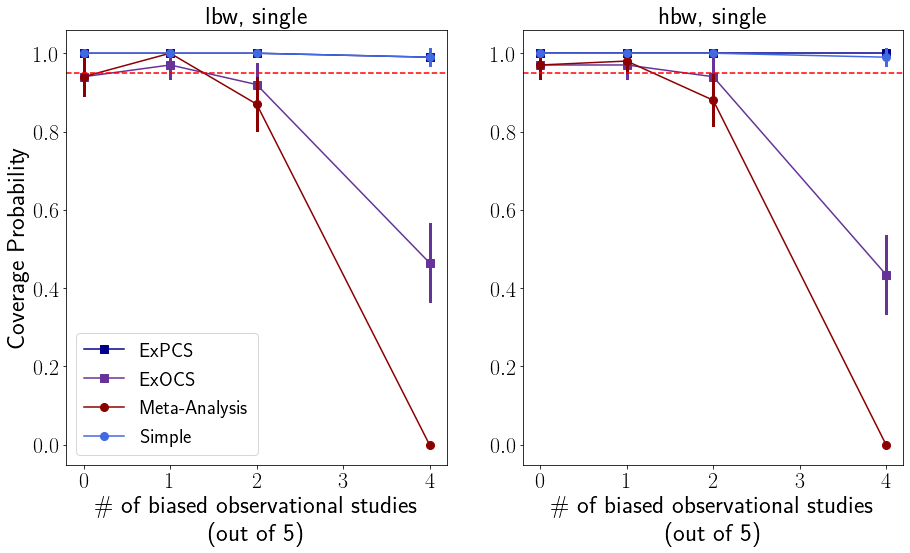

In [44]:
fig, axlist = plt.subplots(1,2,figsize=(15,8))
axs = axlist.ravel()
for i,_ in enumerate(obs_strata_meta): 
    ax = axs[i]
    
    
    coverage_prob_ours = np.array(coverage_prob_dict['ours'][0][i])
    ours_ci = np.array(coverage_prob_dict['ours'][1][i])
    coverage_prob_meta = np.array(coverage_prob_dict['meta'][0][i])
    meta_ci = np.array(coverage_prob_dict['meta'][1][i])
    coverage_prob_evo = np.array(coverage_prob_dict['evo'][0][i])
    evo_ci  = np.array(coverage_prob_dict['evo'][1][i])
    coverage_prob_simple = np.array(coverage_prob_dict['simple'][0][i])
    simple_ci  = np.array(coverage_prob_dict['simple'][1][i])
    prob_correct = np.array(prob_correct_lists[i])
    prob_ci = np.array(prob_correct_ci[i])
    
    # ours
    ax.plot(x, coverage_prob_ours, marker='s', color='darkblue', ms=8, linewidth=1.5, label='ExPCS')
    for k,ci in enumerate(ours_ci): 
        ax.plot((x[k],x[k]),(coverage_prob_ours[k]-ci,coverage_prob_ours[k]+ci), linewidth=3, color='darkblue') 
    # evo
    ax.plot(x, coverage_prob_evo, marker='s', color='rebeccapurple', ms=8, linewidth=1.5, label='ExOCS')
    for k,ci in enumerate(evo_ci): 
        ax.plot((x[k],x[k]),(coverage_prob_evo[k]-ci,coverage_prob_evo[k]+ci), linewidth=3, color='rebeccapurple') 
    # meta
    ax.plot(x, coverage_prob_meta, marker='o', color='darkred', ms=8, linewidth=1.5, label='Meta-Analysis')
    for k,ci in enumerate(meta_ci): 
        ax.plot((x[k],x[k]),(coverage_prob_meta[k]-ci,coverage_prob_meta[k]+ci), linewidth=3, color='darkred') 
    # simple
    ax.plot(x, coverage_prob_simple, marker='o', color='royalblue', ms=8, linewidth=1.5, label='Simple')
    for k,ci in enumerate(simple_ci): 
        ax.plot((x[k],x[k]),(coverage_prob_simple[k]-ci,coverage_prob_simple[k]+ci), linewidth=3, color='royalblue') 
    xmin, xmax = ax.get_xlim()
    ax.axhline(y=0.95,xmin=0,xmax=xmax,color='red',linestyle='--')
    ax.tick_params(axis='y', labelsize=22)
    ax.tick_params(axis='x', labelsize=22)
    ax.set_title(obs_strata_meta[i][1],fontsize=25)
    ax.set_xlabel('$\#$ of biased observational studies\n (out of 5)',fontsize=25)
    if i == 0: 
        legend_properties = {'weight':'bold'}
        ax.set_ylabel('Coverage Probability',fontsize=25)
        ax.legend(fontsize=20,loc='lower left')
fig.savefig('./plots/figure_bias_final_reweight_correction.pdf',bbox_inches='tight')

### Figure 3 (not used)

No handles with labels found to put in legend.


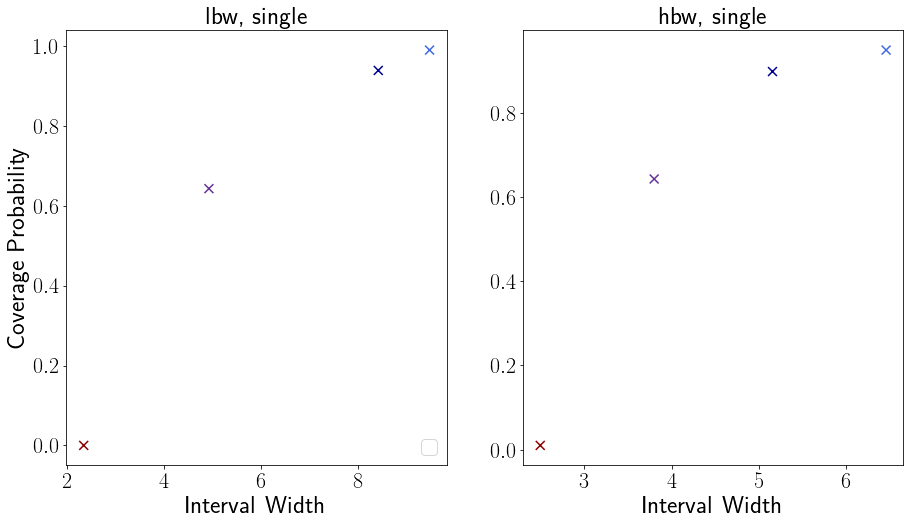

In [37]:
'''
fig, axlist = plt.subplots(1,2,figsize=(15,8))
axs = axlist.ravel()

from matplotlib import colors
color_seq = np.array(['darkblue','darkred','rebeccapurple','royalblue'])
rgb_colors = []
for color in color_seq: 
    rgb_colors.append(colors.to_rgba(color))
rgb_colors = np.array(rgb_colors)

for i,_ in enumerate(obs_strata_meta): 
    ax = axs[i]
    
    cp = []; cp_ci = []
    width = []; width_ci = []
    names = ['ours', 'meta', 'evo', 'simple']
    for name in names: 
        cp.append(coverage_prob_dict[name][0][i][-1])
        cp_ci.append(coverage_prob_dict[name][1][i][-1])
        width.append(interval_width_dict[name][0][i][-1])
        width_ci.append(interval_width_dict[name][1][i][-1])
    cp = np.array(cp); cp_ci = np.array(cp_ci)
    width = np.array(width); width_ci = np.array(width_ci)
    # ours
    ax.scatter(width, cp, marker='x', c=rgb_colors, s=80)

    ax.tick_params(axis='y', labelsize=22)
    ax.tick_params(axis='x', labelsize=22)
    ax.set_title(obs_strata_meta[i][1],fontsize=25)
    ax.set_xlabel('Interval Width',fontsize=25)
    if i == 0: 
        legend_properties = {'weight':'bold'}
        ax.set_ylabel('Coverage Probability',fontsize=25)
        ax.legend(fontsize=20,loc='lower right')
'''